# Response to reviewer #1, comment #5
"The analysis shown in Figure 6 is an interesting one, though it is possible one would get such results purely based on pink noise, too. (Change in) band-limited power in a lower frequency will always be positively correlated with a (change in) a spectral exponent. If one corrects for the rotation, that should remove the correlation (possibly independently of neural mechanisms). Whether the effect reported here is of neural interest or trivially true could easily be checked by a simple simulation (e.g. simulate pink noise of random amplitude, add band-limited oscillation of random amplitude, compute band-limited power of total spectrum, and correlate across simulations before and after 1/f correction)."

### Set path

In [1]:
PROJECT_PATH = 'C:/Users/micha/projects/oscillation_vs_exponent/'

## Set-up

### Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress


In [3]:
from fooof import FOOOF, FOOOFGroup
from fooof.sim import gen_power_spectrum
from neurodsp.spectral import rotate_powerlaw
from fooof.utils import trim_spectrum
from fooof.plts import plot_spectrum

C:\Users\micha\AppData\Local\Temp\ipykernel_9300\3204248945.py:1: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup


### Settings

In [4]:
# analysis settings
ALPHA_BAND = [8, 20]


### Functions

In [5]:
def measure_alpha(params, space='linear', verbose=False):
    """
    compute various alpha power meausres:
    - total band power: mean of the spectrum within the alpha band
    - adjusted band power: mean of the flattened spectrum within the alpha band (aperiodic-adjusted)
    - peak amplitude: maximum of the spectrum within the alpha band
    - adjusted peak amplitude: maximum of the flattened spectrum within the alpha band (aperiodic-adjusted)

    Parameters
    ----------
    params : FOOOF object
        FOOOF object containing the model fit
    space : str, optional
        Frequency space of the model fit, by default 'linear'
    verbose : bool, optional
        Whether to print the results, by default False

    Returns
    -------
    total_band_power : float
        mean of the spectrum within the alpha band
    adjusted_band_power : float
        mean of the flattened spectrum within the alpha band (aperiodic-adjusted)
    peak_amplitude : float
        maximum of the spectrum within the alpha band
    adj_peak_amplitude : float
        maximum of the flattened spectrum within the alpha band (aperiodic-adjusted)    
    """

    # unpack data of interest from params object
    freqs = params.freqs
    spectrum = params.get_model('full', space)
    # spectrum_flat = params.get_model('full', space) - params.get_model('aperiodic', space) # equal to params.get_model('peak', space)
    spectrum_flat = params.get_model('peak', space)

    # measure alpha
    _, alpha_band = trim_spectrum(freqs, spectrum, f_range=ALPHA_BAND)
    _, alpha_band_flat = trim_spectrum(freqs, spectrum_flat, f_range=ALPHA_BAND)
    total_band_power = np.mean(alpha_band)
    adjusted_band_power = np.mean(alpha_band_flat)
    peak_amplitude = np.max(alpha_band)
    adj_peak_amplitude = np.max(alpha_band_flat)

    # print results
    if verbose:
        print(f'total band power:\t{total_band_power:.2f}')
        print(f'adjusted band power:\t{adjusted_band_power:.2f}')
        print(f'peak amplitude:\t\t{peak_amplitude:.2f}')
        print(f'adj. peak amplitude:\t{adj_peak_amplitude:.2f}')

    # return
    return total_band_power, adjusted_band_power, peak_amplitude, adj_peak_amplitude


def regression_plot(df, x_data, y_data, title=None, fname_out=None, show=False):
    """
    Calculate and plot the linear regression of two columns in a dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        dataframe containing the data to plot
    x_data : str
        column with x-values of dataset
    y_data : str
        column with y-values of dataset
    title : str, optional
        Title of the plot
    fname_out : str, optional
        Filename of the output figure
    show : bool, optional
        Whether to show the figure or not

    Returns
    -------
    None
    """

    # imports
    from scipy.stats import linregress
    
    # create figure
    fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
    fig.patch.set_facecolor('white') # set background color to white for text legibility
    
    # plot data
    ax.scatter(df[x_data], df[y_data])

    # run regression and plot results
    results = linregress(df[x_data], df[y_data])
    t_lin = np.linspace(np.nanmin(df[x_data]), np.nanmax(df[x_data]), 100)
    lin = results.slope * t_lin + results.intercept
    ax.plot(t_lin, lin, color='red')

    # add regression results text
    if results.pvalue < 0.001:
        pval = f"{results.pvalue:.2e}"
    else:
        pval = f"{results.pvalue:.3f}"
    plt.text(1.05, 0.9, 
             f"Regression \n" +
             f"    Slope: {results.slope:.3f}\n" +
             f"    Intercept: {results.intercept:.3f}\n" +
             f"    R: {results.rvalue:.3f}\n" +
             f"    p: {pval}", transform = ax.transAxes)

    # label figure
    # ax.legend()
    if title is not None:
        plt.title(title)
    plt.xlabel(x_data.replace('_', ' '))
    plt.ylabel(y_data.replace('_', ' '))
        
    # save/show figure
    if not fname_out is None:
        fig.savefig(fname_out)
    if show:
        plt.show()
    else:
        plt.close()

## Main

### simulate pink noise + oscillation

In [6]:
# settings - spectral parameters
freq_range = [1,100]
params_ap = [1, 2]
params_per = [10, 1, 2]

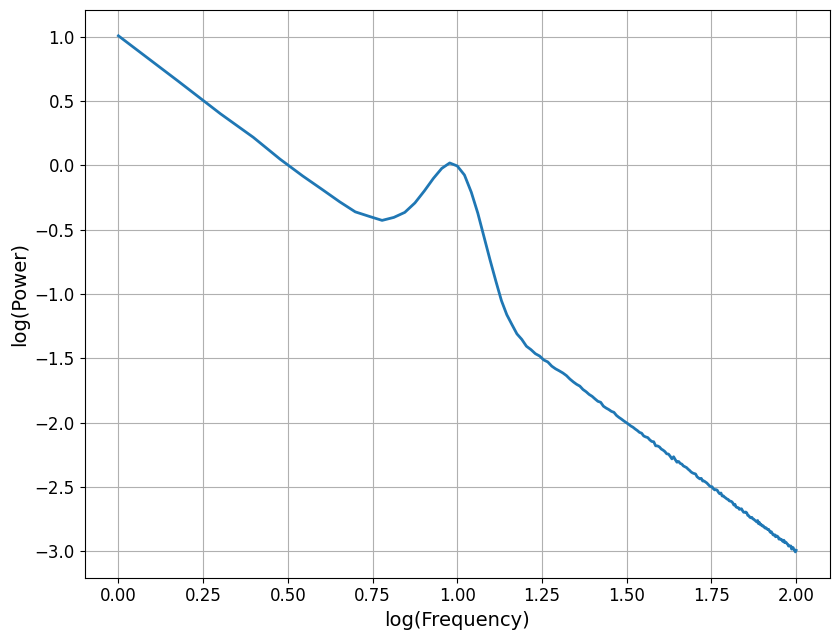

In [7]:
# sim power spectrum (aperiodic + oscilation)
freqs, spectrum = gen_power_spectrum(freq_range, params_ap, params_per)
plot_spectrum(freqs, spectrum, log_freqs=True, log_powers=True)


### parameterize and compute alpha power


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

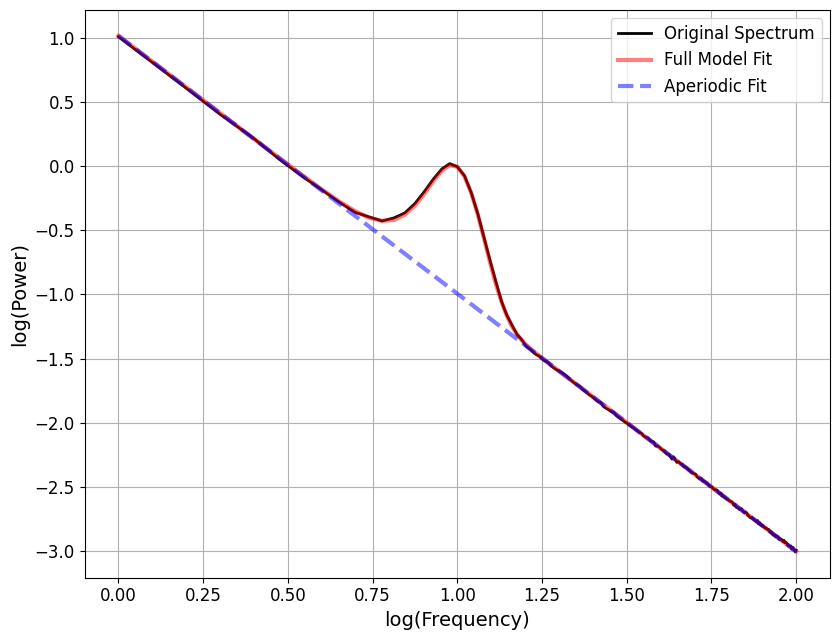

In [8]:
# apply specparam
params = FOOOF()
params.report(freqs, spectrum, plt_log=True)

# measure alpha
total_band_power, adjusted_band_power, peak_amplitude, adj_peak_amplitude = measure_alpha(params, space='log', verbose=True)

### rotate spectrum and correlate exponent change with alpha measures

In [9]:
# aperiodic settings
offset_0 = 10 # initial offset
exponent_0 = 3 # initial exponent
f_rotation = 30 # rotation/intersection frequency (Hz)
delta_exp = -2 # total change in exponent across rotations
n_rotations = 30 # number of rotations

In [10]:
# sim changing exponent over time

# simulate initial spectrum
freqs, temp = gen_power_spectrum(freq_range, [offset_0, exponent_0], params_per)

# init outputs
spectra = np.zeros([n_rotations, len(temp)])
spectra[0] = temp
results = dict({"total_band_power": np.zeros(n_rotations), "adjusted_band_power": np.zeros(n_rotations),
                "peak_amplitude": np.zeros(n_rotations), "adj_peak_amplitude": np.zeros(n_rotations),
                "exp_fit": np.zeros(n_rotations)})

# parameterize initial spectrum and compute alpha measures
params = FOOOF(verbose=False)
params.fit(freqs, spectra[0])
results['total_band_power'][0], results['adjusted_band_power'][0], \
    results['peak_amplitude'][0], results['adj_peak_amplitude'][0] = measure_alpha(params, space='log')
results['exp_fit'][0] = params.get_params('aperiodic_params', 'exponent')

# rotate spectrum and measure alpha
for ii in range(1, n_rotations):
    # rotate spectrum
    spectra[ii] = rotate_powerlaw(freqs, spectra[ii-1], 
                                  delta_exponent=delta_exp/n_rotations, f_rotation=f_rotation)

    # parameterize and compute alpha measures
    params_ii = FOOOF(verbose=False)
    params_ii.fit(freqs, spectra[ii])
    results['total_band_power'][ii], results['adjusted_band_power'][ii], \
        results['peak_amplitude'][ii], results['adj_peak_amplitude'][ii] = measure_alpha(params_ii, space='log') 
    results['exp_fit'][ii] = params_ii.get_params('aperiodic_params', 'exponent')


In [11]:
# # plot the relationship between the exponent and the total/adjusted band power

# for alpha_measure in results.keys():
#     fig, ax = plt.subplots(1,1, figsize=[6,4])
#     ax.scatter(exp_fit, results[alpha_measure])
#     ax.set(xlabel="exponent", ylabel=alpha_measure.replace("_", " "))
#     ax.set_title("")
#     plt.show()


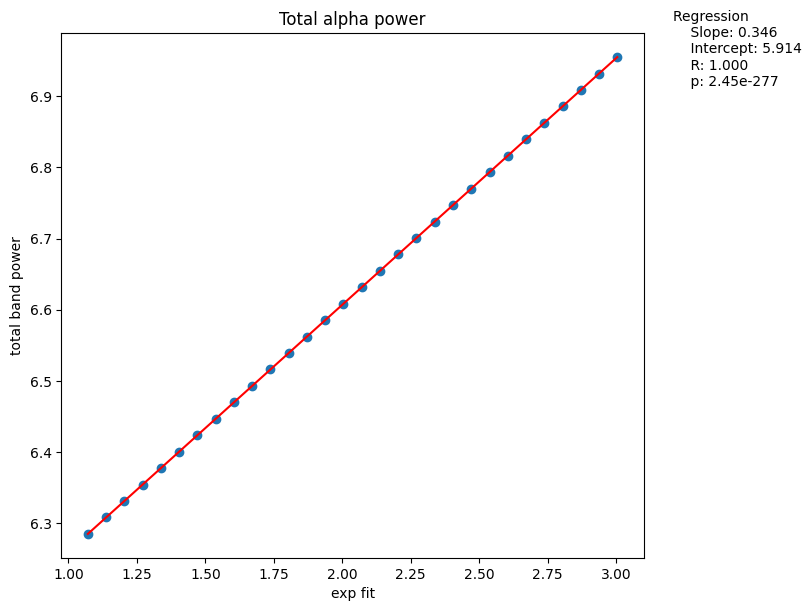

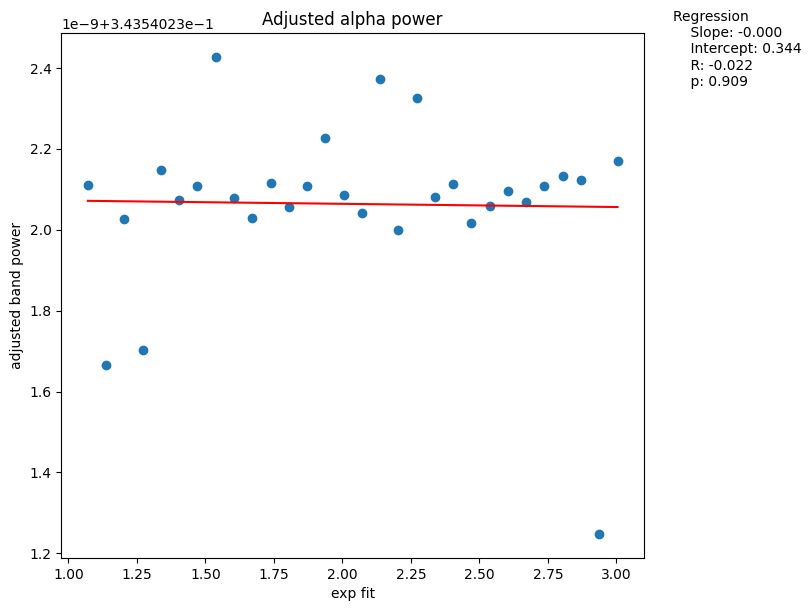

In [12]:
# regression plot
regression_plot(results, 'exp_fit', 'total_band_power', title='Total alpha power', show=True)
regression_plot(results, 'exp_fit', 'adjusted_band_power', title='Adjusted alpha power', show=True)